# Imports

In [1]:
import itertools

import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm

from khan_helpers import Experiment
from khan_helpers.constants import (
    CORRECT_ANSWER_COLOR, 
    FIG_DIR, 
    INCORRECT_ANSWER_COLOR
)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/opt/conda/lib/python3.9/site-packages/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Define some helper functions

In [2]:
def bootstrap_ci(M, ci=95, n_boots=1000, random_state=None):
    """
    Estimate a confidence interval for a given 1D array of observations, 
    or for each row of a 2D array.    
    """
    np.random.seed(random_state)
    M = np.atleast_2d(np.asarray(M))
    rand_ixs = np.random.randint(0, M.shape[1], size=(*M.shape, n_boots))
    boot_means = np.take_along_axis(M[:, np.newaxis], 
                                    rand_ixs, 
                                    axis=2).mean(axis=1)
    ci_low = np.percentile(boot_means, (100 - ci) / 2, axis=1)
    ci_high = np.percentile(boot_means, (ci + 100) / 2, axis=1)
    return [ci_low.item(), ci_high.item()]

In [3]:
def compute_ci_intersections(quiz_group, raw_cis, interp_freq=None):
    """    
    Compute the minimum distance from correctly & incorrectly answered
    reference questions (separately) at which average by-distance 
    p(correct) intersects the confidence interval for average 
    overall/raw p(correct). 
    
    The function is specifically called via 
    `pandas.core.groupby.SeriesGroupBy.agg()`, so the expected format 
    and properties of the arguments are fairly specific.
    
    Parameters
    ----------
    quiz_group : pandas.Series
        A `pandas.Series` that contains average by-distance p(correct) 
        values for a single quiz and has a MultiIndex with 3 levels: 
        "quiz", "accuracy", and "max_dist". 
    raw_cis : pandas.Series
        A `pandas.Series` whose values are iterables of length 2 
        representing lower and upper confidence interval bounds for the 
        accross-participants mean overall/raw p(correct) for each quiz.
    interp_func : float, optional
        If provided, interpolate the series of by-distance p(correct)
        values for each quiz & accuracy of reference question to the 
        given frequency before computing the intersections.
        
    Returns
    -------
    tuple of float
        The minimum distances from correctly (first value) and 
        incorrectly (second value) answered reference questions at which 
        the mean by-distance p(correct) falls within the confidence 
        interval for average overall/raw p(correct). If eiher category's
        series of p(correct) values never intersects the CI, its value
        will be `numpy.nan`.  
    """
    incorrect_means, correct_means = quiz_group.unstack(level=1).T.to_numpy()
    raw_ci_low, raw_ci_high = raw_cis[
        quiz_group.index.get_level_values('quiz')[0]
    ]
    
    if interp_freq is not None:
        dist_vals = np.arange(DIST_BINS[0], DIST_BINS[-1]+interp_freq, interp_freq)
        incorrect_means = np.interp(dist_vals, DIST_BINS, incorrect_means)
        correct_means = np.interp(dist_vals, DIST_BINS, correct_means)
    else:
        dist_vals = DIST_BINS
    
    try:
        correct_intersect = dist_vals[np.nonzero(
            (raw_ci_low <= correct_means) & (correct_means <= raw_ci_high)
        )[0][0]]
    except IndexError:
        correct_intersect = np.nan
    try:
        incorrect_intersect = dist_vals[np.nonzero(
            (raw_ci_low <= incorrect_means) & (incorrect_means <= raw_ci_high)
        )[0][0]]
    except IndexError:
        incorrect_intersect = np.nan
    return correct_intersect, incorrect_intersect

# Compute proportion correct as a function of distance from a reference question

In [4]:
exp = Experiment()

DIST_BINS = np.linspace(0, 2, 201)
ERR_RIBBON_ALPHA = 0.2

In [5]:
datalist = []

pbar = tqdm(total=len(exp.all_data)*len(DIST_BINS), leave=False)

for quiz in range(1, 4):
    for p in exp.participants:
        subid = p.subID
        # data for questions from given quiz
        quiz_data = p.get_data(quiz=quiz-1)
        # accuracy for each question on the quiz
        quiz_accuracies = quiz_data['accuracy']
        # simple proportion correct for the quiz
        quiz_prop_correct = quiz_accuracies.sum() / len(quiz_accuracies)
        # topic vectors for questions from the quiz
        quiz_questions_vecs = exp.question_vectors[quiz_data['qID'] - 1]
        # (correlation) distance matrix for questions on the quiz  
        quiz_questions_dists = cdist(quiz_questions_vecs, 
                                     quiz_questions_vecs, 
                                     'correlation')
        # fix some floating point errors in cdist -- diag should be all 0's
        np.fill_diagonal(quiz_questions_dists, 0)

        # loop over questions on the quiz
        for question_ix in range(len(quiz_questions_dists)):
            qid = quiz_data['qID'].iloc[question_ix]
            if qid == 38:
                pbar.update(len(DIST_BINS))
                continue
            # accuracy for given question
            question_accuracy = quiz_accuracies.iloc[question_ix]
            # (correlation) distance between given question and all 
            # questions on the quiz (including itself)
            question_dists = quiz_questions_dists[question_ix]

            # loop over bins (max distances within which to consider questions)
            for max_dist in DIST_BINS:
                # accuracy on questions within max_dist of reference question
                acc_within_dist = quiz_accuracies[question_dists <= max_dist]
                # number of questions within max_dist of reference question
                n_within_dist = len(acc_within_dist)
                if n_within_dist == 0:
                    # sanity check
                    raise RuntimeError

                datalist.append({
                    'quiz': quiz,
                    'participant': subid,
                    'raw_prop_correct': quiz_prop_correct,
                    'reference_question': qid,
                    'accuracy': question_accuracy,
                    'max_dist': max_dist,
                    'prop_correct': acc_within_dist.sum() / len(acc_within_dist)
                })
                pbar.update()

pbar.close()
df_initial = pd.DataFrame(datalist)
df_initial

  0%|          | 0/391950 [00:00<?, ?it/s]

,quiz,participant,raw_prop_correct,reference_question,accuracy,max_dist,prop_correct
0,1,P1,0.538462,13,1,0.00,1.000000
1,1,P1,0.538462,13,1,0.01,1.000000
2,1,P1,0.538462,13,1,0.02,1.000000
3,1,P1,0.538462,13,1,0.03,1.000000
4,1,P1,0.538462,13,1,0.04,1.000000
...,...,...,...,...,...,...,...
381895,3,P50,0.692308,20,1,1.96,0.692308
381896,3,P50,0.692308,20,1,1.97,0.692308
381897,3,P50,0.692308,20,1,1.98,0.692308
381898,3,P50,0.692308,20,1,1.99,0.692308


# Find distance beyond which knowledge of a particular question predicts knowledge of another question no better than overall proportion correct

In [6]:
# average p(correct) over questions within participants for each quiz & 
# distance bin, split by whether the reference question was answered 
# correctly or incorrectly
sub_avg_df = (
    df_initial
    .groupby(['quiz', 'participant', 'accuracy', 'max_dist'], as_index=False)
    # overall/raw p(correct) has single value per participant/quiz, so 
    # aggregate with 'first' to ffill correct value for each 
    # accuracy/max_dist value
    .agg({'prop_correct': 'mean', 'raw_prop_correct': 'first'})
    # set quiz & participant cols as index for subsampling below
    .set_index(['quiz', 'participant'])
)
sub_avg_df

accuracy  max_dist  prop_correct  raw_prop_correct
quiz participant                                                    
1    P1                  0      0.00      0.000000          0.538462
     P1                  0      0.01      0.166667          0.538462
     P1                  0      0.02      0.166667          0.538462
     P1                  0      0.03      0.166667          0.538462
     P1                  0      0.04      0.166667          0.538462
...                    ...       ...           ...               ...
3    P9                  1      1.96      0.769231          0.769231
     P9                  1      1.97      0.769231          0.769231
     P9                  1      1.98      0.769231          0.769231
     P9                  1      1.99      0.769231          0.769231
     P9                  1      2.00      0.769231          0.769231

[59295 rows x 4 columns]

### Note: cell takes ~10 minutes to run

In [7]:
# number of subsamples for which to compute intersections
N_BOOTS_INTERSECTION = 10_000

np.random.seed(0)
participant_subsamples = np.random.choice(sub_avg_df.index.levels[1].unique(),
                                          size=(N_BOOTS_INTERSECTION, 50),
                                          replace=True)
intersections_dict = {
    (quiz, acc): [] for quiz in range(1, 4) for acc in ('correct', 'incorrect')
}

# drop duplicates before indexing with subsample in order to properly 
# compute subsample CIs for overall/raw p(correct) -- we want repeat 
# values due to random subsampling with replacement, but not from
# sub_avg_df rows that split prop_correct by accuracy/max_dist
sub_avg_raw = sub_avg_df.loc[~sub_avg_df.index.duplicated(), 'raw_prop_correct']

for subsample in tqdm(participant_subsamples, leave=False):
    # MultiIndex row indicies for subsample data from all 3 quizzes
    subsample_ixs = list(itertools.product(range(1, 4), subsample))
    # across-participants mean p(correct) for each quiz & distance bin, 
    # split by reference question correctness
    pcorrect_means = (
        sub_avg_df
        .loc[subsample_ixs]
        .groupby(['quiz', 'accuracy', 'max_dist'])['prop_correct']
        .mean()
    )
    # 95% CI for across-participants mean overall/raw p(correct) for 
    # each quiz
    raw_pcorrect_cis = (
        sub_avg_raw
        .loc[subsample_ixs]
        .groupby('quiz')
        .agg(bootstrap_ci)
    )

    (
        (quiz1_correct, quiz1_incorrect), 
        (quiz2_correct, quiz2_incorrect), 
        (quiz3_correct, quiz3_incorrect)
    )  = (
        pcorrect_means
        .groupby('quiz')
        .agg(compute_ci_intersections, raw_pcorrect_cis)
    )
    intersections_dict[(1, 'correct')].append(quiz1_correct)
    intersections_dict[(1, 'incorrect')].append(quiz1_incorrect)
    intersections_dict[(2, 'correct')].append(quiz2_correct)
    intersections_dict[(2, 'incorrect')].append(quiz2_incorrect)
    intersections_dict[(3, 'correct')].append(quiz3_correct)
    intersections_dict[(3, 'incorrect')].append(quiz3_incorrect)
    
intersections_df = pd.DataFrame(intersections_dict)
intersections_df.columns.names = ('quiz', 'ref_question')
intersections_df.index.name = 'bootstrap'
intersections_df

  0%|          | 0/10000 [00:00<?, ?it/s]

quiz               1                 2                 3          
ref_question correct incorrect correct incorrect correct incorrect
bootstrap                                                         
0               1.11      1.08    1.11      1.11    1.08      1.14
1               1.10      1.09    1.11      1.11    1.10      1.14
2               1.10      1.08    1.11      1.11    1.08       NaN
3               1.11      1.08    1.11      1.11    1.10      1.11
4               1.11      1.08    1.11      1.11    1.10      1.12
...              ...       ...     ...       ...     ...       ...
9995            1.11      1.08    1.11      1.11    1.10      1.13
9996            1.11      1.08    1.11      1.11    1.08      1.11
9997            1.10      1.10    1.11      1.11    1.10      1.13
9998            1.10      1.08    1.11      1.11    1.08      1.13
9999            1.10      1.08    1.11      1.11    1.10      1.11

[10000 rows x 6 columns]

In [8]:
# also compute mean & 95% CIs for by-distance and overall/raw p(correct) 
# from full dataset
pcorrect_full = (
    sub_avg_df
    .groupby(['quiz', 'accuracy', 'max_dist'])['prop_correct']
    .agg(mean='mean', ci=bootstrap_ci)
)
pcorrect_full

mean                                           ci
quiz accuracy max_dist                                                       
1    0        0.00      0.000000                                   [0.0, 0.0]
              0.01      0.052907   [0.03781952561327561, 0.06966452621452622]
              0.02      0.059058   [0.04338915644540645, 0.07616170334295336]
              0.03      0.059058    [0.04364839466089466, 0.0757111050986051]
              0.04      0.059058  [0.043747994829244824, 0.07492435666185665]
...                          ...                                          ...
3    1        1.96      0.784615     [0.7461153846153846, 0.8199999999999997]
              1.97      0.784615                   [0.7461538461538464, 0.82]
              1.98      0.784615      [0.747692307692308, 0.8230769230769229]
              1.99      0.784615     [0.7492307692307695, 0.8215384615384614]
              2.00      0.784615     [0.7430769230769233, 0.8199999999999996]

[1206 rows x 2 columns]

In [9]:
raw_pcorrect_full = sub_avg_raw.groupby('quiz').agg(mean='mean', ci=bootstrap_ci)
raw_pcorrect_full

,mean,ci
quiz,,
1,0.455385,"[0.4092307692307691, 0.5076923076923077]"
2,0.603077,"[0.5538461538461539, 0.6492307692307697]"
3,0.784615,"[0.7491923076923078, 0.8215384615384614]"


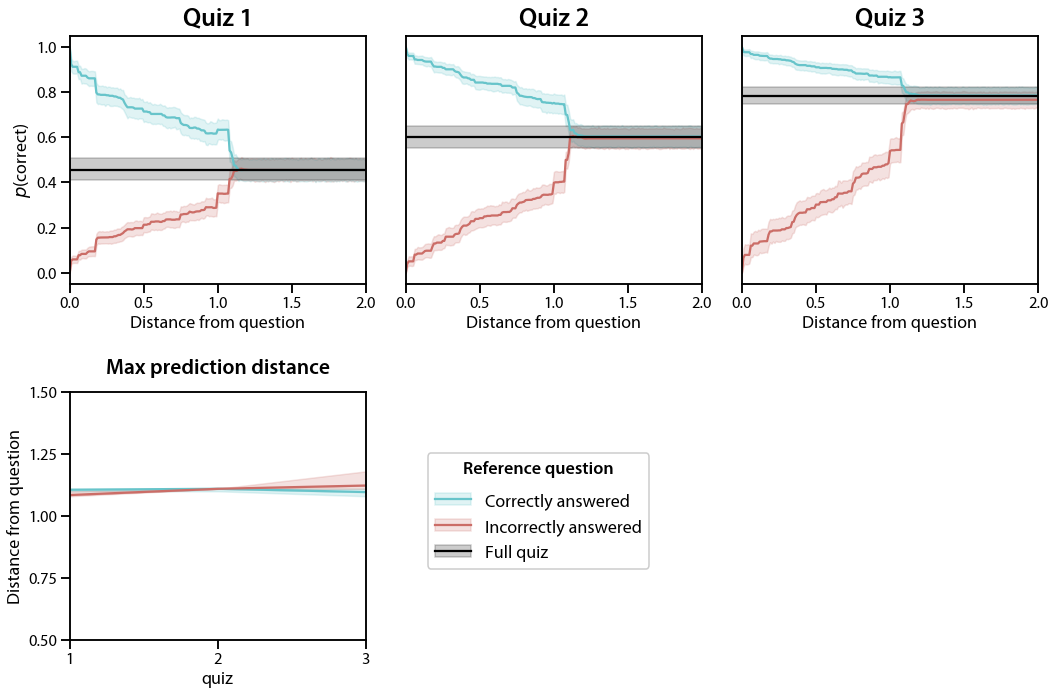

In [10]:
intersections_means = intersections_df.mean(axis=0)
intersections_cis_low = intersections_df.quantile(0.025)
intersections_cis_high = intersections_df.quantile(0.975)
intersections_long = intersections_df.melt(value_name='distance')

with sns.plotting_context('talk'):
    fig, axarr = plt.subplots(2, 3, figsize=(15, 10), sharex=False, sharey='row')
    
    for quiz, ax_top in enumerate(axarr[0], start=1):
        pcorrect_quiz = pcorrect_full.loc[quiz]
        
        # by-distance p(correct) for incorrectly answered reference 
        # questions
        ax_top.plot(DIST_BINS, 
                    pcorrect_quiz.loc[(0,), 'mean'], 
                    color=INCORRECT_ANSWER_COLOR)
        incorrect_ci_low, incorrect_ci_high = np.transpose(
            pcorrect_quiz.loc[(0,), 'ci'].tolist()
        )
        ax_top.fill_between(DIST_BINS, 
                            incorrect_ci_low, 
                            incorrect_ci_high, 
                            color=INCORRECT_ANSWER_COLOR,
                            alpha=ERR_RIBBON_ALPHA)
        
        # by-distance p(correct) for correctly answered reference 
        # questions
        ax_top.plot(DIST_BINS, 
                    pcorrect_quiz.loc[(1,), 'mean'], 
                    color=CORRECT_ANSWER_COLOR)
        correct_ci_low, correct_ci_high = np.transpose(
            pcorrect_quiz.loc[(1,), 'ci'].tolist()
        )
        ax_top.fill_between(DIST_BINS, 
                            correct_ci_low, 
                            correct_ci_high, 
                            color=CORRECT_ANSWER_COLOR,
                            alpha=ERR_RIBBON_ALPHA)
        
        # overall/raw p(correct)
        ax_top.plot(DIST_BINS, 
                    [raw_pcorrect_full.loc[quiz, 'mean']]*len(DIST_BINS), 
                    color='k')
        ax_top.fill_between(DIST_BINS, 
                            *raw_pcorrect_full.loc[quiz, 'ci'], 
                            color='k',
                            alpha=ERR_RIBBON_ALPHA)
        
        ax_top.set_title(f'Quiz {quiz}', 
                         y=1.02, 
                         fontsize='x-large', 
                         fontweight='semibold')
        ax_top.set_xlabel('Distance from question')
        ax_top.set_xlim(0, 2)
        if quiz == 1:
            ax_top.set_ylabel('$p$(correct)')
        else:
            ax_top.tick_params(left=False)
        
    ax_bottom = axarr[1, 0]
    sns.lineplot(data=intersections_long, 
                 x='quiz', 
                 y='distance', 
                 hue='ref_question', 
                 palette=[CORRECT_ANSWER_COLOR, INCORRECT_ANSWER_COLOR], 
                 legend=False,
                 ax=ax_bottom)
    ax_bottom.fill_between((1, 2, 3), 
                           intersections_cis_low.loc[:, 'correct'], 
                           intersections_cis_high.loc[:, 'correct'],
                           color=CORRECT_ANSWER_COLOR,
                           alpha=ERR_RIBBON_ALPHA)
    ax_bottom.fill_between((1, 2, 3), 
                           intersections_cis_low.loc[:, 'incorrect'], 
                           intersections_cis_high.loc[:, 'incorrect'],
                           color=INCORRECT_ANSWER_COLOR,
                           alpha=ERR_RIBBON_ALPHA)
    ax_bottom.set_title('Max prediction distance', 
                        y=1.05, 
                        fontsize='large', 
                        fontweight='semibold')
    ax_bottom.set_ylabel('Distance from question')
    ax_bottom.set_ylim(0.5, 1.5)
    ax_bottom.set_yticks(np.arange(0.5, 1.51, 0.25))
    ax_bottom
    ax_bottom.set_xlim(1, 3)
    ax_bottom.set_xticks((1, 2, 3))
    
    axarr[1, 1].axis('off')
    axarr[1, 2].axis('off')
    
    # manual legend
    correct_line2d, incorrect_line2d = ax_bottom.lines
    correct_errband, incorrect_errband = ax_bottom.collections[2:4]
    raw_line2d = ax_top.lines[-1]
    raw_errband = ax_top.collections[-1]
    leg = fig.legend(handles=((correct_line2d, correct_errband), 
                              (incorrect_line2d, incorrect_errband), 
                              (raw_line2d, raw_errband)),
                     labels=('Correctly answered', 
                             'Incorrectly answered', 
                             'Full quiz'),
                     title='Reference question',
                     title_fontproperties={'weight': 'semibold'},
                     loc='lower center',
                     fontsize='medium',
                     framealpha=1, 
                     bbox_to_anchor=(0.51, 0.18))
    leg._legend_box.sep = 15
    plt.tight_layout(h_pad=1.5)
#     plt.savefig(FIG_DIR.joinpath('knowledge-smoothness.pdf'), bbox_inches='tight')
    plt.show()